Your goal is to predict the binary class <b>heart_disease_present</b>, which represents whether or not a patient has heart disease:

 - 0 represents no heart disease present
 - 1 represents heart disease present

Performance is evaluated according to <b>binary log loss.</b>

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
import pandas as pd
from IPython.core.display import display, HTML
# %matplotlib notebook
# %matplotlib notebook
import matplotlib.pyplot as plt
# %matplotlib notebook
# %matplotlib notebook
import warnings
warnings.filterwarnings('ignore')

%reload_ext autoreload
%autoreload 2
%matplotlib inline

pd.set_option('display.max_rows', 800)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 100)

display(HTML("<style>.container { width:100% !important; }</style>"))

import warnings
warnings.filterwarnings('ignore')

import os, glob
import cv2
import dlib
import pandas as pd
import numpy as np
from scipy.spatial.distance import cdist, euclidean
from scipy import stats
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

from skimage.feature import greycomatrix, greycoprops
from skimage.measure import shannon_entropy
from sklearn.model_selection import train_test_split
# import the necessary packages
from skimage import feature, io, color
from scipy.stats import moment, describe
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import log_loss
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import GridSearchCV

import statsmodels.formula.api as smfapi
import statsmodels.api as smapi
from scipy.stats import f as f_test

from Utils.DataUtils import *
from Utils.UtilsViz import *


import warnings
warnings.filterwarnings('ignore')

from imblearn.over_sampling import SMOTE

In [22]:
train_features = pd.read_csv("./data/train_values.csv")
train_labels = pd.read_csv("./data/train_labels.csv")
test_features = pd.read_csv("./data/test_values.csv")

In [23]:
data = pd.merge(train_features, train_labels)

In [4]:
display(
    data.head(),
    data.shape)

,patient_id,slope_of_peak_exercise_st_segment,thal,resting_blood_pressure,chest_pain_type,num_major_vessels,fasting_blood_sugar_gt_120_mg_per_dl,resting_ekg_results,serum_cholesterol_mg_per_dl,oldpeak_eq_st_depression,sex,age,max_heart_rate_achieved,exercise_induced_angina,heart_disease_present
0,0z64un,1,normal,128,2,0,0,2,308,0.0,1,45,170,0,0
1,ryoo3j,2,normal,110,3,0,0,0,214,1.6,0,54,158,0,0
2,yt1s1x,1,normal,125,4,3,0,2,304,0.0,1,77,162,1,1
3,l2xjde,1,reversible_defect,152,4,0,0,0,223,0.0,1,40,181,0,1
4,oyt4ek,3,reversible_defect,178,1,0,0,2,270,4.2,1,59,145,0,0


(180, 15)

In [5]:
analyse_nans(data)

,patient_id,slope_of_peak_exercise_st_segment,thal,resting_blood_pressure,chest_pain_type,num_major_vessels,fasting_blood_sugar_gt_120_mg_per_dl,resting_ekg_results,serum_cholesterol_mg_per_dl,oldpeak_eq_st_depression,sex,age,max_heart_rate_achieved,exercise_induced_angina,heart_disease_present
total,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
percentage,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
idx_list,[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]


In [6]:
# sns.pairplot(data, diag_kind="kde")

In [7]:
cat_vars = ["slope_of_peak_exercise_st_segment", "thal", "chest_pain_type", "resting_ekg_results", "sex", "exercise_induced_angina"]
for cv in cat_vars:
    data[cv] = data[cv].astype("category")
data.head()

,patient_id,slope_of_peak_exercise_st_segment,thal,resting_blood_pressure,chest_pain_type,num_major_vessels,fasting_blood_sugar_gt_120_mg_per_dl,resting_ekg_results,serum_cholesterol_mg_per_dl,oldpeak_eq_st_depression,sex,age,max_heart_rate_achieved,exercise_induced_angina,heart_disease_present
0,0z64un,1,normal,128,2,0,0,2,308,0.0,1,45,170,0,0
1,ryoo3j,2,normal,110,3,0,0,0,214,1.6,0,54,158,0,0
2,yt1s1x,1,normal,125,4,3,0,2,304,0.0,1,77,162,1,1
3,l2xjde,1,reversible_defect,152,4,0,0,0,223,0.0,1,40,181,0,1
4,oyt4ek,3,reversible_defect,178,1,0,0,2,270,4.2,1,59,145,0,0


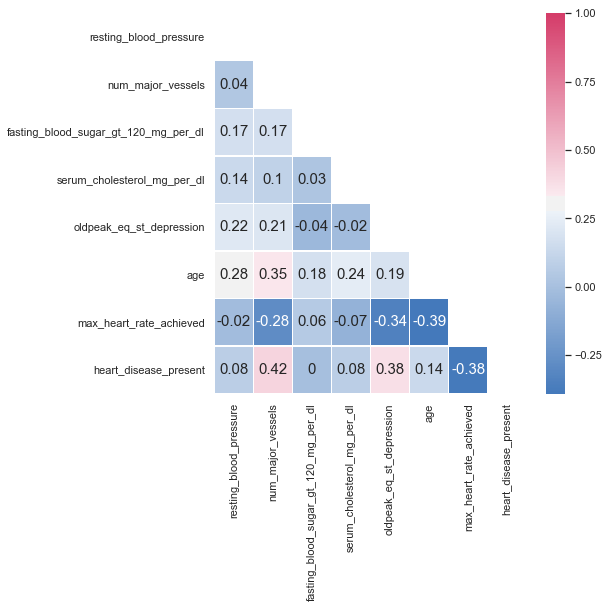

In [8]:
f, ax = plt.subplots(1,1,figsize=(7,7))
plot_corr_heatmap(np.round(data.corr(),2), ax=ax, annotate=True)

In [25]:
data.to_csv("./data/analysis.csv", index=False)

------------

------------

------------

#  Encoding

In [9]:
data, lenc_dict = labelencode_collist(data, cat_vars)
data, ohe_dict = onehotencode_collist(data, cat_vars)
data.head()

,patient_id,resting_blood_pressure,num_major_vessels,fasting_blood_sugar_gt_120_mg_per_dl,serum_cholesterol_mg_per_dl,oldpeak_eq_st_depression,age,max_heart_rate_achieved,heart_disease_present,slope_of_peak_exercise_st_segment_0,slope_of_peak_exercise_st_segment_1,thal_0,thal_1,chest_pain_type_0,chest_pain_type_1,chest_pain_type_2,resting_ekg_results_0,resting_ekg_results_1,sex_0,exercise_induced_angina_0
0,0z64un,128,0,0,308,0.0,45,170,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
1,ryoo3j,110,0,0,214,1.6,54,158,0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,yt1s1x,125,3,0,304,0.0,77,162,1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0
3,l2xjde,152,0,0,223,0.0,40,181,1,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,oyt4ek,178,0,0,270,4.2,59,145,0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


In [10]:
# Drop the patient ID
drop_cols = ["patient_id"]
for c in drop_cols:
    if c in data.columns:
        data.drop(labels=c, inplace=True, axis=1)

In [11]:
ycol = ["heart_disease_present"]
xcol = [c for c in data.columns if c.lower() not in ycol]

------

------

------

# Scaling

In [12]:
data, scaler_dict = scale_collist(data, xcol)
data = data[xcol + ycol]

In [13]:
data.head()

,resting_blood_pressure,num_major_vessels,fasting_blood_sugar_gt_120_mg_per_dl,serum_cholesterol_mg_per_dl,oldpeak_eq_st_depression,age,max_heart_rate_achieved,slope_of_peak_exercise_st_segment_0,slope_of_peak_exercise_st_segment_1,thal_0,thal_1,chest_pain_type_0,chest_pain_type_1,chest_pain_type_2,resting_ekg_results_0,resting_ekg_results_1,sex_0,exercise_induced_angina_0,heart_disease_present
0,-0.195195,-0.718403,-0.438238,1.118269,-0.903207,-1.053964,0.932485,-0.845154,-0.267261,0.914732,-0.835532,2.329929,-0.680746,-0.914732,-0.074744,0.956501,0.672022,-0.680746,0
1,-1.256320,-0.718403,-0.438238,-0.669778,0.527616,-0.087134,0.387084,1.183216,-0.267261,0.914732,-0.835532,-0.429198,1.468977,-0.914732,-0.074744,-1.045478,-1.488048,-0.680746,0
2,-0.372049,2.385097,-0.438238,1.042182,-0.903207,2.383654,0.568884,-0.845154,-0.267261,0.914732,-0.835532,-0.429198,-0.680746,1.093216,-0.074744,0.956501,0.672022,1.468977,1
3,1.219639,-0.718403,-0.438238,-0.498582,-0.903207,-1.591092,1.432436,-0.845154,-0.267261,-1.093216,1.196843,-0.429198,-0.680746,1.093216,-0.074744,-1.045478,0.672022,-0.680746,1
4,2.752375,-0.718403,-0.438238,0.395442,2.852703,0.449994,-0.203768,-0.845154,3.741657,-1.093216,1.196843,-0.429198,-0.680746,-0.914732,-0.074744,0.956501,0.672022,-0.680746,0


------------

------------

------------

#  Train Test Split

In [14]:
train_data, test_data = train_test_split(data, test_size=0.3)
x_train = train_data[xcol].values
y_train = train_data[ycol].values
x_test = test_data[xcol].values
y_test = test_data[ycol].values

------------

------------

------------

# Random Forest Classifier - Baseline

In [15]:
rfc = RandomForestClassifier()
rfc = rfc.fit(x_train, y_train)

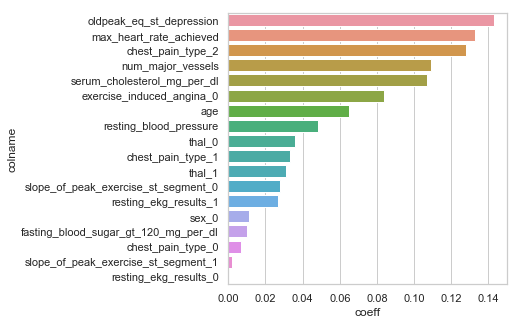

In [16]:
coeff_df = pd.DataFrame(list(zip(xcol, np.round(rfc.feature_importances_, 3))))
coeff_df.columns = ["colname", "coeff"]
coeff_df.sort_values(by="coeff", inplace=True, ascending=False)
f, ax = plt.subplots(1,1,figsize=(5,5))
g = sns.barplot(y="colname", x="coeff", data=coeff_df, ax=ax)

In [17]:
rsq = rfc.score(x_train, y_train)
adjusted_r_squared = 1 - (1 - rsq)*(len(y_train)-1) /\
                            (len(y_train) - x_train.shape[1] - 1)

print("Adjusted Rsq. :", adjusted_r_squared)


y_pred_train = rfc.predict(X=x_train)
y_pred_test = rfc.predict(X=x_test)

ll_train = log_loss(y_train, y_pred_train)
ll_test = log_loss(y_test, y_pred_test)

print("Train set Log Loss: {:.2f}".format(ll_train))
print("Test set Log Loss: {:.2f}".format(ll_test))

Adjusted Rsq. : 0.9629135143153835
Train set Log Loss: 1.10
Test set Log Loss: 6.40


------------

------------

------------

# RF Classifier - Grid Search

In [18]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': list(np.arange(1,10,1))+[None],
    'max_features': list(np.arange(0.1,0.5,0.1)),
    'min_samples_leaf': [1, 2, 3, 4, 5],
    'min_samples_split': list(np.arange(0.1, 0.3, 0.1)),
    'n_estimators': [40, 50]
}
# Create a based model
rfc = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rfc, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 2)

# Fit the grid search to the data
grid_search.fit(x_train, y_train)

best_grid = grid_search.best_estimator_

Fitting 5 folds for each of 800 candidates, totalling 4000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:   23.9s
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:   33.2s
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed:   44.4s
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed:   58.7s
[Parallel(n_jobs=-1)]: Done 3265 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 4000 out of 4000 | elapsed:  1.5min finished


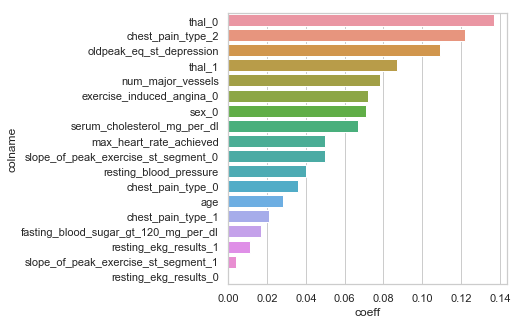

In [19]:
rfc = best_grid
coeff_df = pd.DataFrame(list(zip(xcol, np.round(rfc.feature_importances_, 3))))
coeff_df.columns = ["colname", "coeff"]
coeff_df.sort_values(by="coeff", inplace=True, ascending=False)
f, ax = plt.subplots(1,1,figsize=(5,5))
g = sns.barplot(y="colname", x="coeff", data=coeff_df, ax=ax)

In [20]:
rsq = rfc.score(x_train, y_train)
adjusted_r_squared = 1 - (1 - rsq)*(len(y_train)-1) /\
                            (len(y_train) - x_train.shape[1] - 1)

print("Adjusted Rsq. :", adjusted_r_squared)


y_pred_train = rfc.predict(X=x_train)
y_pred_test = rfc.predict(X=x_test)

ll_train = log_loss(y_train, y_pred_train)
ll_test = log_loss(y_test, y_pred_test)

print("Train set Log Loss: {:.2f}".format(ll_train))
print("Test set Log Loss: {:.2f}".format(ll_test))

Adjusted Rsq. : 0.8331108144192256
Train set Log Loss: 4.93
Test set Log Loss: 5.76
